# Plateforme de recommandation des produits Chanel

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import keras
import tensorflow as tf
from keras import *

# Configuration
IMG_SIZE = (224, 224)  # Taille standard pour ResNet, VGG, etc.
CACHE_DIR = "images_cache"
CHECKPOINT_DIR = "checkpoints"
BATCH_SIZE = 16
SEED = 42



## Partie 2 : Comparaison des embeddings visuels

#### Fonction de chargement du checkpoint

Cette fonction permet de charger rapidement les données depuis le checkpoint créé dans la partie 1.

In [5]:
def load_checkpoint(checkpoint_dir="checkpoints"):
    """
    Charge les données depuis le checkpoint.
    Retourne le DataFrame et le LabelEncoder.
    """
    import pickle
    
    data_path = os.path.join(checkpoint_dir, "data_with_images.csv")
    encoder_path = os.path.join(checkpoint_dir, "label_encoder.pkl")
    
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Checkpoint non trouvé : {data_path}")
    
    # Charger les données
    df = pd.read_csv(data_path)
    
    # Vérifier que les images existent toujours
    valid_mask = df['image_path'].apply(lambda x: os.path.exists(x) if pd.notna(x) else False)
    if not valid_mask.all():
        print(f"Attention: {(~valid_mask).sum()} images manquantes dans le cache")
    
    # Charger le LabelEncoder
    with open(encoder_path, 'rb') as f:
        le = pickle.load(f)
    
    print(f"Checkpoint chargé : {len(df)} entrées")
    return df, le

# Pour charger depuis le checkpoint (décommenter si besoin) :
data_valid, label_encoder = load_checkpoint()
num_classes = len(label_encoder.classes_)

Checkpoint chargé : 898 entrées


#### Split train/validation/test

On divise les données en trois ensembles : 70% train, 15% validation, 15% test. On utilise une stratification pour conserver la distribution des classes.

In [6]:
# Filtrer les classes avec trop peu d'échantillons pour la stratification
min_samples_per_class = 3
class_counts = data_valid['label'].value_counts()
valid_classes = class_counts[class_counts >= min_samples_per_class].index
data_stratifiable = data_valid[data_valid['label'].isin(valid_classes)].copy()
all_images = data_stratifiable.copy()

print(f"Classes avec au moins {min_samples_per_class} échantillons : {len(valid_classes)} / {num_classes}")
print(f"Échantillons utilisables pour stratification : {len(data_stratifiable)} / {len(data_valid)}")

# Split train/temp (70/30) — stratifié
train_data, temp_data = train_test_split(
    data_stratifiable,
    test_size=0.3,
    stratify=data_stratifiable['label'],
    random_state=SEED,
)

# Essayer un split stratifié pour val/test ; si impossible, fallback non-stratifié
from sklearn.exceptions import NotFittedError

try:
    # Split temp en validation/test (50/50 de 30% = 15/15) — stratifié si possible
    val_data, test_data = train_test_split(
        temp_data,
        test_size=0.5,
        stratify=temp_data['label'],
        random_state=SEED,
    )
except ValueError as e:
    print("Warning: stratified split failed for temp_data (certaines classes ont <2 échantillons).")
    print("Détail :", e)
    print("Affichage des tailles de classes dans temp_data :")
    print(temp_data['label'].value_counts().sort_values().head(20))
    print("Fallback : split non-stratifié pour val/test.")
    val_data, test_data = train_test_split(
        temp_data,
        test_size=0.5,
        stratify=None,
        random_state=SEED,
    )

print(f"\nRépartition des données :")
print(f"  - Train : {len(train_data)} ({len(train_data)/len(data_stratifiable):.1%})")
print(f"  - Validation : {len(val_data)} ({len(val_data)/len(data_stratifiable):.1%})")
print(f"  - Test : {len(test_data)} ({len(test_data)/len(data_stratifiable):.1%})")

Classes avec au moins 3 échantillons : 32 / 39
Échantillons utilisables pour stratification : 889 / 898
Détail : The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Affichage des tailles de classes dans temp_data :
label
4     1
13    1
7     1
25    1
27    1
20    1
31    1
36    2
9     2
29    2
1     2
30    2
8     2
18    3
19    4
23    4
11    5
2     6
15    6
0     7
Name: count, dtype: int64
Fallback : split non-stratifié pour val/test.

Répartition des données :
  - Train : 622 (70.0%)
  - Validation : 133 (15.0%)
  - Test : 134 (15.1%)


#### Chargement des images en arrays NumPy

On charge les images depuis le cache et on les convertit en arrays NumPy normalisés (pixels entre 0 et 1).

In [7]:
def load_images_to_array(df, desc="Chargement"):
    """
    Charge toutes les images d'un DataFrame en un array NumPy.
    Les pixels sont normalisés entre 0 et 1.
    """
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        # Charger l'image
        img = Image.open(row['image_path'])
        # Convertir en array et normaliser
        img_array = np.array(img) / 255.0
        images.append(img_array)
        labels.append(row['label'])
    
    return np.array(images), np.array(labels)

print("Fonction de chargement définie.")

Fonction de chargement définie.


On charge les images en arrays NumPy :

In [8]:
# Charger les images en arrays NumPy
X_train, y_train = load_images_to_array(train_data, desc="Train")
X_val, y_val = load_images_to_array(val_data, desc="Validation")
X_test, y_test = load_images_to_array(test_data, desc="Test")

# Charger toutes les images pour les embeddings
X_all, y_all = load_images_to_array(all_images, desc="Toutes les images")

# Vérification
print(f"\nDonnées chargées :")
print(f"  - Train : {X_train.shape}, labels : {y_train.shape}")
print(f"  - Validation : {X_val.shape}, labels : {y_val.shape}")
print(f"  - Test : {X_test.shape}, labels : {y_test.shape}")
print(f"  - Total : {X_all.shape}")
print(f"\nPlage de valeurs des pixels : [{X_train.min():.3f}, {X_train.max():.3f}]")

Train:   0%|          | 0/622 [00:00<?, ?it/s]

Toutes les images: 100%|██████████| 889/889 [00:00<00:00, 1963.13it/s]



Données chargées :
  - Train : (622, 224, 224, 3), labels : (622,)
  - Validation : (133, 224, 224, 3), labels : (133,)
  - Test : (134, 224, 224, 3), labels : (134,)
  - Total : (889, 224, 224, 3)

Plage de valeurs des pixels : [0.000, 1.000]


## Construction des modèles

### 1. Méthodes pour extraire les embeddings visuels

#### Méthode 1 : Modèle entraîné pour la classification

Entrainement d'un CNN pour classifier les images selon category2_code

In [9]:
cnn_model = Sequential([
    keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), 
    layers.Conv2D(32, (5, 5), activation='relu', name="conv_1"),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3 ,3), activation='relu', name="conv_2"),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', name="conv_3"),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', name="dense_1"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax', name="dense_2")
])

cnn_model.build((None, IMG_SIZE[0], IMG_SIZE[1], 3))

cnn_model.summary()

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.2,           
    patience=5,           
    min_lr=0.000001,       
    verbose=1             
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,575,015 (36.53 MB)

 Trainable params: 9,575,015 (36.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_embeddings_path = os.path.join(CHECKPOINT_DIR, "embeddings", "cnn_embeddings.npy")
if os.path.exists(cnn_embeddings_path):
    print(f"Embeddings déjà calculés : {cnn_embeddings_path}")
else:
    cnn_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = cnn_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=20,
        callbacks=[reduce_lr]
    )

Epoch 1/20


### Création du modèle d'embedding à partir du modèle CNN entrainé

Sauvegarde des embeddings des images.

In [ ]:
if os.path.exists(cnn_embeddings_path):
    print(f"Embeddings déjà calculés : {cnn_embeddings_path}")
else:
    # Créer le modèle d'embedding (sortie de la couche dense_1)
    embedding_model = Model(
        inputs=cnn_model.layers[0].input,
        outputs=cnn_model.get_layer('dense_1').output
    )

    # Calculer les embeddings sur toutes les images
    cnn_embeddings = embedding_model.predict(X_all, batch_size=BATCH_SIZE, verbose=1)

    print(f"Embeddings shape: {cnn_embeddings.shape}")

    # Associer les embeddings au DataFrame
    all_images = all_images.reset_index(drop=True)
    all_images['cnn_embedding'] = list(cnn_embeddings)

Embeddings déjà calculés : checkpoints/embeddings/cnn_embeddings.npy


#### Méthode 2 : Utilisation d’un modèle pré-entraîné

In [ ]:

# Charger ConvNeXt pré-entraîné sur ImageNet
convnext_encoder = applications.convnext.ConvNeXtTiny(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling='avg'
)

# Geler les poids du modèle pré-entraîné
convnext_encoder.trainable = False

class PreTrainedClassifier(keras.Model):
    def __init__(self, encoder, num_classes):
        super(PreTrainedClassifier, self).__init__()
        self.encoder = encoder
        
        # ajouter 2 couche Dense pour obtenir des embeddings de taille 256, 
        # et une couche de sortie softmax pour la classification
        self.dense1 = layers.Dense(256, activation='relu', name='convnext_dense_1')
        self.dense2 = layers.Dense(num_classes, activation='softmax', name='convnext_dense_2')

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.dense1(x)
        return self.dense2(x)

convnext_model = PreTrainedClassifier(convnext_encoder, num_classes=num_classes)
convnext_model.build((None, IMG_SIZE[0], IMG_SIZE[1], 3))
convnext_model.summary()

# Compiler le modèle ConvNeXt
convnext_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Prétraitement spécifique à ConvNeXt (normalisation ImageNet)
X_train_convnext = applications.convnext.preprocess_input(X_train * 255)  # Remettre en 0-255 pour le preprocessing
X_val_convnext = applications.convnext.preprocess_input(X_val * 255)      # Remettre en 0-255 pour le preprocessing


/home/vkretz/Programming/ai/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'pre_trained_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "pre_trained_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 768)            │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_dense_1 (Dense)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_dense_2 (Dense)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,820,128 (106.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,820,128 (106.13 MB)

In [ ]:
convnext_embeddings_path = os.path.join(CHECKPOINT_DIR, "embeddings", "convnext_embeddings.npy")
if os.path.exists(convnext_embeddings_path):
    print(f"Embeddings ConvNeXt déjà existants : {convnext_embeddings_path}, saut de l'entraînement.")
else:
    # Entraîner le modèle ConvNeXt
    history_convnext_head = convnext_model.fit(
        X_train_convnext, y_train,
        validation_data=(X_val_convnext, y_val),
        batch_size=BATCH_SIZE,
        epochs=20,
        callbacks=[reduce_lr]
    )

    # Dégeler le modèle ConvNeXt pour un fine-tuning
    convnext_encoder.trainable = True

    convnext_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.00003),  # Learning rate plus bas pour le fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history_convnext = convnext_model.fit(
        X_train_convnext, y_train,
        validation_data=(X_val_convnext, y_val),
        batch_size=BATCH_SIZE,
        epochs=5,
        callbacks=[reduce_lr]
    )

Embeddings ConvNeXt déjà existants : checkpoints/embeddings/convnext_embeddings.npy, saut de l'entraînement.


### Extraction des embeddings

In [ ]:
if os.path.exists(convnext_embeddings_path):
    # Charger les embeddings depuis le fichier
    convnext_embeddings = np.load(convnext_embeddings_path)
    print(f"Embeddings ConvNeXt chargés depuis : {convnext_embeddings_path}")
else:
    X_all_preprocessed = applications.convnext.preprocess_input(X_all * 255)  # Remettre en 0-255 pour le preprocessing

    # Calculer les embeddings
    inputs = convnext_encoder.input
    encoder_out = convnext_encoder.output  # tenseur symbolique
    embeddings_tensor = convnext_model.dense1(encoder_out)  # couche Dense déjà instanciée
    convnext_embedding_model = Model(inputs=inputs, outputs=embeddings_tensor)

    # Calculer les embeddings
    convnext_embeddings = convnext_embedding_model.predict(X_all_preprocessed, batch_size=BATCH_SIZE, verbose=1)


    print(f"ConvNeXt embeddings shape: {convnext_embeddings.shape}")
    # Associer les embeddings au DataFrame
    all_images = all_images.reset_index(drop=True)
    all_images['convnext_embedding'] = list(convnext_embeddings)

Embeddings ConvNeXt chargés depuis : checkpoints/embeddings/convnext_embeddings.npy


#### Sauvegarde des embeddings (checkpoint)

On sauvegarde les embeddings calculés pour éviter de devoir les recalculer. On utilise numpy pour les embeddings et pickle pour le DataFrame complet.

In [ ]:
# Sauvegarde des embeddings
embeddings_dir = os.path.join(CHECKPOINT_DIR, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Sauvegarder les embeddings en numpy
cnn_embeddings = None
convnext_embeddings = None
np.save(os.path.join(embeddings_dir, "cnn_embeddings.npy"), cnn_embeddings)
np.save(os.path.join(embeddings_dir, "convnext_embeddings.npy"), convnext_embeddings)

# Sauvegarder le DataFrame avec les embeddings (en pickle car les colonnes contiennent des listes)
all_images.to_pickle(os.path.join(embeddings_dir, "all_images_with_embeddings.pkl"))

print(f"Embeddings sauvegardés dans {embeddings_dir}/")
print(f"  - cnn_embeddings.npy : {os.path.getsize(os.path.join(embeddings_dir, 'cnn_embeddings.npy')) / 1024 / 1024:.2f} MB")
print(f"  - convnext_embeddings.npy : {os.path.getsize(os.path.join(embeddings_dir, 'convnext_embeddings.npy')) / 1024 / 1024:.2f} MB")
print(f"  - all_images_with_embeddings.pkl : {os.path.getsize(os.path.join(embeddings_dir, 'all_images_with_embeddings.pkl')) / 1024 / 1024:.2f} MB")

Embeddings sauvegardés dans checkpoints/embeddings/
  - cnn_embeddings.npy : 0.00 MB
  - convnext_embeddings.npy : 0.00 MB
  - all_images_with_embeddings.pkl : 0.44 MB


In [ ]:
def load_embeddings_checkpoint(checkpoint_dir="checkpoints"):
    """
    Charge les embeddings depuis le checkpoint.
    Retourne le DataFrame all_images et les arrays numpy des embeddings.
    """
    embeddings_dir = os.path.join(checkpoint_dir, "embeddings")
    
    # Charger le DataFrame
    df = pd.read_pickle(os.path.join(embeddings_dir, "all_images_with_embeddings.pkl"))
    
    # Charger les embeddings numpy
    cnn_emb = np.load(os.path.join(embeddings_dir, "cnn_embeddings.npy"))
    convnext_emb = np.load(os.path.join(embeddings_dir, "convnext_embeddings.npy"))
    
    print(f"Embeddings chargés : {len(df)} images")
    print(f"  - CNN: {cnn_emb.shape}")
    print(f"  - ConvNeXt: {convnext_emb.shape}")
    
    return df, cnn_emb, convnext_emb

# Pour charger depuis le checkpoint (décommenter si besoin) :
all_images, cnn_embeddings, convnext_embeddings = load_embeddings_checkpoint()

Embeddings chargés : 891 images
  - CNN: ()
  - ConvNeXt: ()


#### Méthode 3 : Self-supervised learning

On implémente un apprentissage auto-supervisé avec l'approche **SimCLR** (Simple Contrastive Learning of Visual Representations).

**Principe de SimCLR :**
1. Pour chaque image, on génère deux vues augmentées différentes
2. L'encodeur apprend à rapprocher les représentations des deux vues d'une même image (paire positive)
3. Et à éloigner les représentations d'images différentes (paires négatives)

Cette méthode permet d'apprendre des représentations visuelles sans utiliser les labels.

In [ ]:
# SimCLR nécessite des augmentations FORTES pour apprendre 
# des représentations robustes

class SimCLRAugmentationSimple(layers.Layer):
    """
    Version simplifiée sans tensorflow_addons.
    Utilise des augmentations natives TensorFlow plus fortes.
    """
    def __init__(self, img_size=224, **kwargs):
        super().__init__(**kwargs)
        self.img_size = img_size
        
    def call(self, images, training=True):
        if not training:
            return images
            
        batch_size = tf.shape(images)[0]
        
        # 1. Random resized crop (20-100% de l'image) - CRUCIAL!
        scale = tf.random.uniform([], 0.3, 1.0)
        crop_size = tf.cast(tf.cast(self.img_size, tf.float32) * scale, tf.int32)
        crop_size = tf.maximum(crop_size, 48)
        images = tf.image.random_crop(images, [batch_size, crop_size, crop_size, 3])
        images = tf.image.resize(images, [self.img_size, self.img_size])
        
        # 2. Random flip horizontal
        images = tf.image.random_flip_left_right(images)
        
        # 3. Color jitter fort
        images = tf.image.random_brightness(images, 0.4)
        images = tf.image.random_contrast(images, 0.6, 1.4)
        images = tf.image.random_saturation(images, 0.6, 1.4)
        images = tf.image.random_hue(images, 0.1)
        
        # 4. Random grayscale (20%)
        def to_gray(img):
            gray = tf.image.rgb_to_grayscale(img)
            return tf.concat([gray, gray, gray], axis=-1)
        
        images = tf.cond(
            tf.random.uniform([]) < 0.2,
            lambda: to_gray(images),
            lambda: images
        )
        
        return tf.clip_by_value(images, 0.0, 1.0)


# ============================================
# 2. Encodeur AMÉLIORÉ avec BatchNorm et backbone plus profond
# ============================================

def create_encoder_simple(input_shape=(224, 224, 3), embedding_dim=256):
    """
    Encodeur CNN amélioré avec BatchNormalization.
    Architecture plus profonde pour de meilleures représentations.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Backbone CNN avec BatchNorm
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(512, (3, 3), padding='same')(x)  # Couche supplémentaire
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Couche d'embedding avec BN
    x = layers.Dense(embedding_dim)(x)
    x = layers.BatchNormalization()(x)
    embeddings = layers.Activation('relu', name='embeddings')(x)
    
    return Model(inputs, embeddings, name='encoder')


def create_encoder_resnet(input_shape=(224, 224, 3), embedding_dim=256):
    """
    Encodeur basé sur ResNet50 pré-entraîné.
    Bien meilleur pour des petits datasets!
    """
    # Backbone ResNet50 pré-entraîné
    base_model = applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    
    # Congeler les premières couches (optionnel)
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.Dense(embedding_dim)(x)
    x = layers.BatchNormalization()(x)
    embeddings = layers.Activation('relu', name='embeddings')(x)
    
    return Model(inputs, embeddings, name='encoder_resnet')


def create_projection_head(embedding_dim=256, projection_dim=128):
    """
    Projection head (MLP) amélioré pour SimCLR.
    Architecture: embedding_dim -> embedding_dim -> projection_dim
    """
    return tf.keras.Sequential([
        layers.Dense(embedding_dim),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(projection_dim),  # Pas d'activation sur la dernière couche
    ], name='projection_head')

print("Modules SimCLR AMÉLIORÉS créés ✓")
print("Améliorations:")
print("  - Augmentations FORTES (random crop, color jitter, grayscale)")
print("  - BatchNormalization dans l'encodeur")
print("  - Architecture plus profonde (5 couches conv)")
print("  - Option ResNet50 pré-entraîné disponible")

Modules SimCLR AMÉLIORÉS créés ✓
Améliorations:
  - Augmentations FORTES (random crop, color jitter, grayscale)
  - BatchNormalization dans l'encodeur
  - Architecture plus profonde (5 couches conv)
  - Option ResNet50 pré-entraîné disponible


In [ ]:
# ============================================
# 3. Perte contrastive NT-Xent AMÉLIORÉE
# ============================================

def nt_xent_loss(z_i, z_j, temperature=0.1):
    """
    Calcule la perte NT-Xent (Normalized Temperature-scaled Cross Entropy).
    
    Args:
        z_i, z_j: Représentations des deux vues augmentées
        temperature: Température pour la softmax (0.07-0.1 recommandé!)
    
    Returns:
        Perte contrastive moyenne
    """
    batch_size = tf.shape(z_i)[0]
    
    # Normaliser les vecteurs (L2 norm)
    z_i = tf.nn.l2_normalize(z_i, axis=1)
    z_j = tf.nn.l2_normalize(z_j, axis=1)
    
    # Concaténer les deux vues: [z_i; z_j] shape: (2B, D)
    z = tf.concat([z_i, z_j], axis=0)
    
    # Matrice de similarité cosinus: (2B, 2B)
    similarity = tf.matmul(z, z, transpose_b=True) / temperature
    
    # Créer le masque pour exclure l'auto-similarité (diagonale)
    batch_size_2 = 2 * batch_size
    mask = tf.eye(batch_size_2, dtype=tf.float32)
    
    # Appliquer le masque: -inf sur la diagonale
    similarity = similarity - mask * 1e9
    
    # Labels: pour chaque z_i[k], le positif est z_j[k] (à position k+B)
    # Pour chaque z_j[k], le positif est z_i[k] (à position k)
    labels = tf.concat([
        tf.range(batch_size, 2 * batch_size),  # z_i -> z_j
        tf.range(0, batch_size)                 # z_j -> z_i
    ], axis=0)
    
    # Cross-entropy loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, 
        logits=similarity
    )
    
    return tf.reduce_mean(loss)


# Memory Bank pour simuler un grand batch (optionnel mais très utile!)
class MemoryBank:
    """
    Memory bank pour stocker les embeddings précédents.
    Permet de simuler un grand batch même avec peu de mémoire GPU.
    """
    def __init__(self, size=4096, dim=128):
        self.size = size
        self.dim = dim
        self.bank = tf.Variable(
            tf.random.normal([size, dim]), 
            trainable=False,
            name='memory_bank'
        )
        self.ptr = tf.Variable(0, trainable=False, dtype=tf.int32)
        
    def update(self, embeddings):
        """Ajoute de nouveaux embeddings au bank"""
        batch_size = tf.shape(embeddings)[0]
        embeddings = tf.nn.l2_normalize(embeddings, axis=1)
        
        # Indices où insérer
        ptr = self.ptr
        end_ptr = (ptr + batch_size) % self.size
        
        # Mise à jour circulaire
        if end_ptr > ptr:
            self.bank[ptr:end_ptr].assign(embeddings)
        else:
            remaining = self.size - ptr
            self.bank[ptr:].assign(embeddings[:remaining])
            self.bank[:end_ptr].assign(embeddings[remaining:])
        
        self.ptr.assign(end_ptr)
        
    def get_negatives(self):
        """Retourne tous les embeddings stockés"""
        return self.bank

print("Fonction de perte NT-Xent AMÉLIORÉE définie ✓")
print("  - Température réduite à 0.1 (recommandé: 0.07-0.1)")
print("  - Memory Bank disponible pour simuler grands batchs")

Fonction de perte NT-Xent AMÉLIORÉE définie ✓
  - Température réduite à 0.1 (recommandé: 0.07-0.1)
  - Memory Bank disponible pour simuler grands batchs


In [ ]:
# ============================================
# 4. Modèle SimCLR complet AMÉLIORÉ
# ============================================

class SimCLRModel(Model):
    """
    Modèle SimCLR amélioré pour l'apprentissage auto-supervisé.
    Avec warmup du learning rate et suivi de la perte.
    """
    def __init__(self, encoder, projection_head, augmentation, temperature=0.1):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.augmentation = augmentation
        self.temperature = temperature
        
    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, images):
        # Générer deux vues augmentées INDÉPENDANTES
        view_1 = self.augmentation(images, training=True)
        view_2 = self.augmentation(images, training=True)
        
        with tf.GradientTape() as tape:
            # Encoder les deux vues
            h_1 = self.encoder(view_1, training=True)
            h_2 = self.encoder(view_2, training=True)
            
            # Projeter dans l'espace contrastif
            z_1 = self.projection_head(h_1, training=True)
            z_2 = self.projection_head(h_2, training=True)
            
            # Calculer la perte contrastive
            loss = nt_xent_loss(z_1, z_2, self.temperature)
        
        # Gradient et update
        trainable_vars = self.encoder.trainable_variables + self.projection_head.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Gradient clipping pour stabilité
        gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)
        
        return {'loss': self.loss_tracker.result()}
    
    def get_embeddings(self, images):
        """Retourne les embeddings (sans la projection head)."""
        return self.encoder(images, training=False)


# Learning rate scheduler avec warmup (très important pour SimCLR!)
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Learning rate schedule avec warmup linéaire puis décroissance cosinus.
    Crucial pour l'entraînement stable de SimCLR.
    """
    def __init__(self, base_lr, total_steps, warmup_steps):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        
        # Warmup linéaire
        warmup_lr = self.base_lr * (step / self.warmup_steps)
        
        # Cosine decay après warmup
        decay_steps = self.total_steps - self.warmup_steps
        decay_step = step - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.cos(3.14159 * decay_step / decay_steps))
        decay_lr = self.base_lr * cosine_decay
        
        return tf.where(step < self.warmup_steps, warmup_lr, decay_lr)
    
    def get_config(self):
        return {
            'base_lr': self.base_lr,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }

print("Classe SimCLRModel AMÉLIORÉE définie ✓")
print("Améliorations:")
print("  - Gradient clipping pour stabilité")
print("  - Learning rate scheduler avec warmup disponible")
print("  - Température par défaut à 0.1")

Classe SimCLRModel AMÉLIORÉE définie ✓
Améliorations:
  - Gradient clipping pour stabilité
  - Learning rate scheduler avec warmup disponible
  - Température par défaut à 0.1


#### Entraînement du modèle SimCLR

On entraîne le modèle SimCLR sur nos images **sans utiliser les labels**. Le modèle apprend à créer des représentations qui regroupent les vues augmentées d'une même image.

In [ ]:
# ============================================
# Configuration OPTIMISÉE pour SimCLR
# ============================================

# Paramètres clés - AJUSTÉS pour de meilleures performances
SIMCLR_EMBEDDING_DIM = 256
SIMCLR_PROJECTION_DIM = 128
SIMCLR_TEMPERATURE = 0.1  # Réduit! (était 0.5, recommandé: 0.07-0.1)
SIMCLR_EPOCHS = 20  # Augmenté! (était 20)
SIMCLR_BATCH_SIZE = 64  # Augmenté! (était 16) - Plus de négatifs par batch

# Choix de l'encodeur: 'simple' (CNN léger) ou 'resnet' (ResNet50 pré-entraîné)
ENCODER_TYPE = 'simple'  # Utiliser 'resnet' pour de meilleures performances

# Créer l'augmentation FORTE
augmentation = SimCLRAugmentationSimple(img_size=IMG_SIZE[0])

# Créer l'encodeur selon le choix
if ENCODER_TYPE == 'resnet':
    print("Utilisation de ResNet50 pré-entraîné comme encodeur...")
    encoder = create_encoder_resnet(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), 
        embedding_dim=SIMCLR_EMBEDDING_DIM
    )
else:
    print("Utilisation du CNN personnalisé comme encodeur...")
    encoder = create_encoder_simple(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), 
        embedding_dim=SIMCLR_EMBEDDING_DIM
    )

# Créer la projection head
projection_head = create_projection_head(
    embedding_dim=SIMCLR_EMBEDDING_DIM, 
    projection_dim=SIMCLR_PROJECTION_DIM
)

# Calculer les steps pour le scheduler
n_samples = len(all_images)  # Utilise all_images (données filtrées avec images valides)
steps_per_epoch = n_samples // SIMCLR_BATCH_SIZE
total_steps = steps_per_epoch * SIMCLR_EPOCHS
warmup_steps = steps_per_epoch * 5  # 5 epochs de warmup

# Learning rate scheduler
lr_schedule = WarmUpCosineDecay(
    base_lr=0.001,  # LR de base
    total_steps=total_steps,
    warmup_steps=warmup_steps
)

# Créer le modèle SimCLR
simclr_model = SimCLRModel(
    encoder=encoder,
    projection_head=projection_head,
    augmentation=augmentation,
    temperature=SIMCLR_TEMPERATURE
)

# Compiler avec le scheduler
simclr_model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule))

print(f"\n{'='*50}")
print(f"Modèle SimCLR OPTIMISÉ créé:")
print(f"{'='*50}")
print(f"  • Encodeur: {ENCODER_TYPE.upper()}")
print(f"  • Dimension embeddings: {SIMCLR_EMBEDDING_DIM}")
print(f"  • Dimension projection: {SIMCLR_PROJECTION_DIM}")
print(f"  • Température: {SIMCLR_TEMPERATURE} (←←← IMPORTANTE!)")
print(f"  • Batch size: {SIMCLR_BATCH_SIZE} (plus grand = mieux)")
print(f"  • Epochs: {SIMCLR_EPOCHS}")
print(f"  • Warmup: {warmup_steps} steps ({warmup_steps//steps_per_epoch} epochs)")
print(f"  • Augmentations: FORTES (crop, color jitter, grayscale)")
print(f"{'='*50}\n")

encoder.summary()

Utilisation du CNN personnalisé comme encodeur...

Modèle SimCLR OPTIMISÉ créé:
  • Encodeur: SIMPLE
  • Dimension embeddings: 256
  • Dimension projection: 128
  • Température: 0.1 (←←← IMPORTANTE!)
  • Batch size: 64 (plus grand = mieux)
  • Epochs: 20
  • Warmup: 65 steps (5 epochs)
  • Augmentations: FORTES (crop, color jitter, grayscale)



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,32

 Total params: 1,704,896 (6.50 MB)

 Trainable params: 1,702,400 (6.49 MB)

 Non-trainable params: 2,496 (9.75 KB)

Entraînement SimCLR sur 891 images...
Batch size: 64 | Epochs: 20
Steps par epoch: 13
--------------------------------------------------
Epoch 1/20
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.7916  → Learning rate: 0.000215
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 3.6642
Epoch 2/20
  → Learning rate: 0.000215
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 3.6642
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.0648  → Learning rate: 0.000431
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.0239
Epoch 3/20
  → Learning rate: 0.000431
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.0239
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.6087  → Learning rate: 0.000646
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 2.7845
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.6087  → Learning rate: 0.000646
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 2.7845
Epoch 4/20
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.3590  → Learning rate: 0.00

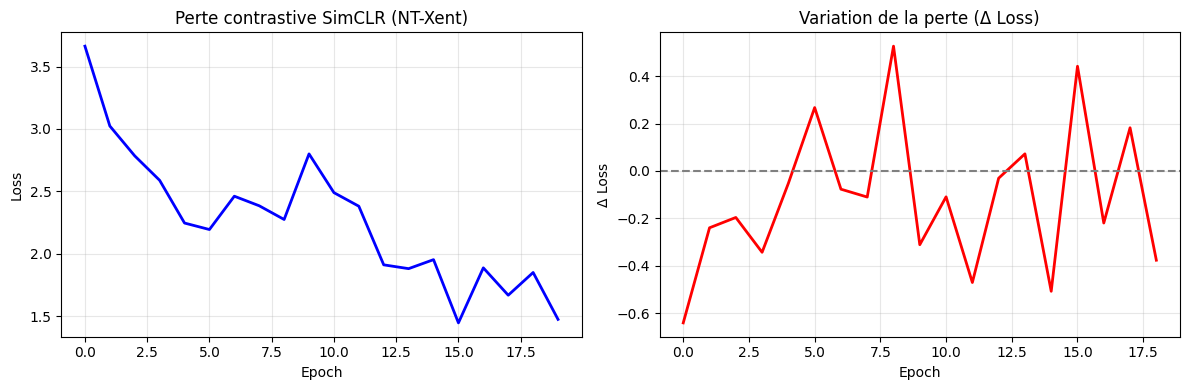


Perte finale: 1.4731


In [ ]:
# Entraînement de SimCLR OPTIMISÉ
print(f"Entraînement SimCLR sur {len(X_all)} images...")
print(f"Batch size: {SIMCLR_BATCH_SIZE} | Epochs: {SIMCLR_EPOCHS}")
print(f"Steps par epoch: {len(X_all) // SIMCLR_BATCH_SIZE}")
print("-" * 50)

# Callbacks adaptés
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,  # Augmenté car warmup peut causer des fluctuations
    restore_best_weights=True,
    min_delta=0.001
)

# Callback pour afficher le learning rate
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model.optimizer, 'learning_rate'):
            lr = self.model.optimizer.learning_rate
            if callable(lr):
                current_lr = float(lr(self.model.optimizer.iterations))
            else:
                current_lr = float(lr)
            print(f"  → Learning rate: {current_lr:.6f}")

history_simclr = simclr_model.fit(
    X_all,
    epochs=SIMCLR_EPOCHS,
    batch_size=SIMCLR_BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, LRLogger()]
)

# Visualiser la courbe de perte
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_simclr.history['loss'], 'b-', linewidth=2)
plt.title('Perte contrastive SimCLR (NT-Xent)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Calculer la différence entre epochs consécutifs
loss_diff = np.diff(history_simclr.history['loss'])
plt.plot(loss_diff, 'r-', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Variation de la perte (Δ Loss)')
plt.xlabel('Epoch')
plt.ylabel('Δ Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPerte finale: {history_simclr.history['loss'][-1]:.4f}")
# Sauvegarde du modèle SimCLR entraîné
simclr_model_path = os.path.join(CHECKPOINT_DIR, "simclr_model")
simclr_model.save(simclr_model_path)
print(f"Modèle SimCLR sauvegardé dans : {simclr_model_path}")

#### Extraction des embeddings SimCLR

Une fois entraîné, on extrait les embeddings de l'encodeur (sans la projection head) pour les utiliser dans notre système de recommandation.

In [ ]:
# Extraire les embeddings SimCLR
simclr_embeddings = simclr_model.get_embeddings(X_all)
simclr_embeddings = simclr_embeddings.numpy()

print(f"SimCLR embeddings shape: {simclr_embeddings.shape}")

# Ajouter au DataFrame
all_images['simclr_embedding'] = list(simclr_embeddings)

# Sauvegarder les embeddings SimCLR
np.save(os.path.join(embeddings_dir, "simclr_embeddings.npy"), simclr_embeddings)
print(f"Embeddings SimCLR sauvegardés")

NameError: name 'simclr_model' is not defined

### 2. Comparaison des trois méthodes

Analyser la qualité des embeddings sur des critères comme la cohérence intra-classe et les distances inter-classe. 
* Sélectionner des exemples représentatifs (par exemple, un sac, un parfum, un produit cosmétique) et comparer les distances entre leurs embeddings générés par les trois méthodes. 
* Visualisation des embeddings (via t-SNE ou UMAP) pour illustrer les regroupements.

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# On suppose que vous avez une colonne 'label' ou 'class' dans all_images
# et que vos embeddings sont stockés sous forme de liste ou array numpy dans le dataframe

# 1. Préparer les matrices (N_images, Dimensions)
X_cnn = np.stack(all_images['cnn_embedding'].values)      # Shape (N, 256)
X_convnext = np.stack(all_images['convnext_embedding'].values) # Shape (N, 256)
y_labels = all_images['label'].values # Vos vraies classes

# 2. Calculer le score (entre -1 et 1. Plus c'est haut, mieux c'est)
score_cnn = silhouette_score(X_cnn, y_labels, metric='cosine')
score_convnext = silhouette_score(X_convnext, y_labels, metric='cosine')

print("=== Qualité du clustering (Silhouette Score) ===")
print(f"  CNN (256d)       : {score_cnn:.4f}")
print(f"  ConvNeXt (256d)  : {score_convnext:.4f}")

# Vérifier si SimCLR est disponible
if 'simclr_embedding' in all_images.columns:
    X_simclr = np.stack(all_images['simclr_embedding'].values)
    score_simclr = silhouette_score(X_simclr, y_labels, metric='cosine')
    print(f"  SimCLR (256d)    : {score_simclr:.4f}")

from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

# 1. Calculer toutes les distances par paires pour chaque modèle
dists_cnn = pdist(X_cnn, metric='cosine')
dists_convnext = pdist(X_convnext, metric='cosine')

# 2. Calculer la corrélation de Pearson entre ces distances
correlation, _ = pearsonr(dists_cnn, dists_convnext)
print(f"\nCorrélation entre CNN et ConvNeXt : {correlation:.4f}")

if 'simclr_embedding' in all_images.columns:
    dists_simclr = pdist(X_simclr, metric='cosine')
    corr_cnn_simclr, _ = pearsonr(dists_cnn, dists_simclr)
    corr_convnext_simclr, _ = pearsonr(dists_convnext, dists_simclr)
    print(f"Corrélation entre CNN et SimCLR    : {corr_cnn_simclr:.4f}")
    print(f"Corrélation entre ConvNeXt et SimCLR: {corr_convnext_simclr:.4f}")

=== Qualité du clustering (Silhouette Score) ===
  CNN (256d)       : 0.3581
  ConvNeXt (256d)  : 0.3674
  SimCLR (256d)    : -0.4633

Corrélation entre CNN et ConvNeXt : 0.7227
Corrélation entre CNN et SimCLR    : -0.0048
Corrélation entre ConvNeXt et SimCLR: 0.0807
Corrélation entre CNN et SimCLR    : -0.0048
Corrélation entre ConvNeXt et SimCLR: 0.0807


Calcul t-SNE pour CNN...
Calcul t-SNE pour ConvNeXt...
Calcul t-SNE pour ConvNeXt...
Calcul t-SNE pour SimCLR...
Calcul t-SNE pour SimCLR...


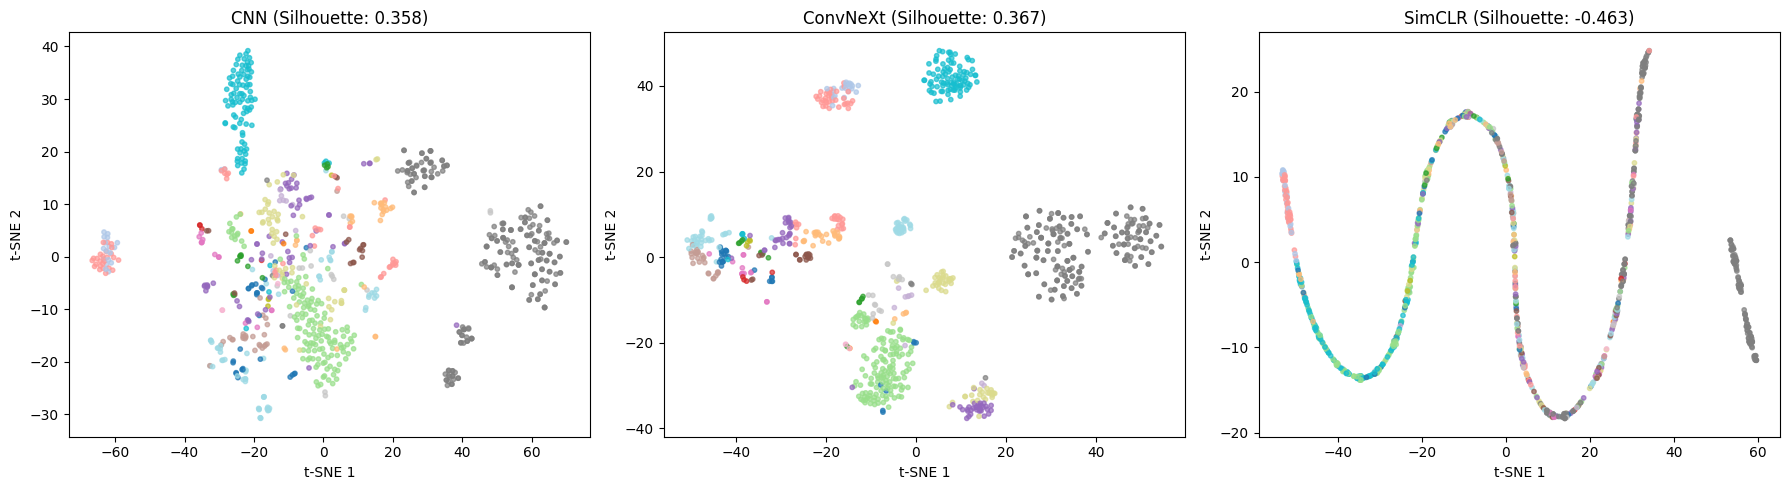


=== Interprétation ===
Un score Silhouette plus élevé indique que les embeddings
séparent mieux les différentes catégories de produits.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduire à 2 dimensions avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

print("Calcul t-SNE pour CNN...")
cnn_2d = tsne.fit_transform(X_cnn)

print("Calcul t-SNE pour ConvNeXt...")
convnext_2d = tsne.fit_transform(X_convnext)

# Nombre de plots selon si SimCLR est disponible
n_plots = 3 if 'simclr_embedding' in all_images.columns else 2

fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

# Plot CNN
scatter1 = axes[0].scatter(cnn_2d[:, 0], cnn_2d[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
axes[0].set_title(f"CNN (Silhouette: {score_cnn:.3f})")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Plot ConvNeXt
scatter2 = axes[1].scatter(convnext_2d[:, 0], convnext_2d[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
axes[1].set_title(f"ConvNeXt (Silhouette: {score_convnext:.3f})")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

# Plot SimCLR si disponible
if 'simclr_embedding' in all_images.columns:
    print("Calcul t-SNE pour SimCLR...")
    simclr_2d = tsne.fit_transform(X_simclr)
    scatter3 = axes[2].scatter(simclr_2d[:, 0], simclr_2d[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    axes[2].set_title(f"SimCLR (Silhouette: {score_simclr:.3f})")
    axes[2].set_xlabel("t-SNE 1")
    axes[2].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

print("\n=== Interprétation ===")
print("Un score Silhouette plus élevé indique que les embeddings")
print("séparent mieux les différentes catégories de produits.")